<a href="https://colab.research.google.com/github/Avinandan22/ProbabilisticMachineLearning-PClub/blob/master/Auto_Encoding_Variational_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from torch.autograd import Variable

In [0]:
batch_size = 100
imagesize = 28
lr = 1e-3
hidden_size = 2
outf = "./MNIST_VAE_SAMPLES/"

In [0]:
dataset = dset.MNIST(root = './MNIST',
                     train = True,
                     transform = transforms.Compose([
                         transforms.ToTensor()
                         ,]),
                     download = True)
loader = torch.utils.data.DataLoader(dataset = dataset,
                               batch_size = batch_size,
                               shuffle = True)

In [0]:
class VAE(nn.Module):
    def __init__(self ,hidden_size = 2):
        super(VAE ,self).__init__()

        n = 64

        self.conv1 = nn.Sequential(nn.Conv2d(1 ,n ,kernel_size = 4 ,stride = 2 ,padding = 1) ,
                                  nn.BatchNorm2d(n) ,
                                  nn.LeakyReLU(0.2 ,inplace = True))

        self.conv2 = nn.Sequential(nn.Conv2d(n ,2 * n ,kernel_size = 3 ,stride = 1 ,padding = 1) ,
                                  nn.BatchNorm2d(2 * n) ,
                                  nn.LeakyReLU(0.2 ,inplace = True))

        self.conv3 = nn.Sequential(nn.Conv2d(2 * n ,n ,kernel_size = 4 ,stride = 2 ,padding = 1) ,
                                  nn.BatchNorm2d(n) ,
                                  nn.LeakyReLU(0.2 ,inplace = True))

        self.conv4 = nn.Sequential(nn.Conv2d(n ,n ,kernel_size = 3 ,stride = 1 ,padding = 1) ,
                                  nn.BatchNorm2d(n) ,
                                  nn.LeakyReLU(0.2 ,inplace = True))

        self.fc11 = nn.Linear(n * 7 * 7 ,hidden_size)
        self.fc12 = nn.Linear(n * 7 * 7 ,hidden_size)
        self.fc2 = nn.Linear(hidden_size ,n * 7 * 7)


        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(n ,n ,kernel_size = 3 ,stride = 1 ,padding = 1) ,
                                    nn.BatchNorm2d(n) ,
                                    nn.ReLU())

        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(n ,2 * n ,kernel_size = 4 ,stride = 2 ,padding = 1) ,
                                    nn.BatchNorm2d(2 * n) ,
                                    nn.ReLU())

        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(2 * n ,n ,kernel_size = 3 ,stride = 1 ,padding = 1) ,
                                    nn.BatchNorm2d(n) ,
                                    nn.ReLU())

        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(n ,1 ,kernel_size = 4 ,stride = 2 ,padding = 1) ,
                                    nn.Sigmoid())
    def encoder(self ,x):
      out = self.conv1(x)
      out = self.conv2(out)
      out = self.conv3(out)
      out = self.conv4(out)
      return self.fc11(out.view(out.size(0) ,-1)) ,self.fc12(out.view(out.size(0) ,-1))


    def decoder(self ,x):
        out = self.fc2(x)
        out = self.deconv1(out.view(x.size(0), 64, 7, 7))
        out = self.deconv2(out)
        out = self.deconv3(out)
        out = self.deconv4(out)
        return out

    def sampler(self ,mu ,logvar):
        var = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(var.size()).normal_()
        eps = Variable(eps)
        if(use_cuda):
            eps = eps.cuda()
        return eps.mul(var).add_(mu)

    def forward(self ,x):
        mu ,logvar = self.encoder(x)
        out = self.sampler(mu ,logvar)
        out = self.decoder(out)
        return out ,mu ,logvar



In [0]:
if torch.cuda.is_available():
  use_cuda = True
else:
  use_cuda = False

In [0]:
model = VAE()
if use_cuda :
  model.cuda()
bce = nn.BCELoss()
bce.size_average = False
optimizer = optim.Adam(model.parameters())

In [0]:
def criterion(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0) # normalize by batch size
    return loss

In [0]:
def train(model,optimizer,dataloader,num_epochs):
    losses = []
    model.train()
    epoch_losses = []
    for epoch in range(num_epochs):
        epoch_loss = []
        for i,(images,_) in enumerate(dataloader):
            
            x = Variable(images)
            model.zero_grad()
            x = x.cuda()
            x_out, z_mu, z_logvar = model.forward(x)
            loss = criterion(x_out,x,z_mu,z_logvar)
            loss.backward()
            optimizer.step()
#             print(loss)
            losses.append(format(loss))
            epoch_loss.append(format(loss))
#             losses.append(tensor.item(loss.data[0]))
            
            if i % 100 == 0 : 
                print("loss = {} epoch = {} minibatch = {}/600".format(sum([float(x) for x in epoch_loss])/(i+1),epoch,i))
#                 losses.append(format(loss))
#                 print(losses)
#         print(epoch_losses)
        epoch_losses.append(sum([float(x) for x in epoch_loss])/600)
        print("Epoch {} completed . Epoch loss = {}".format(epoch+1,sum([float(x) for x in epoch_loss])/(600)))
    return losses,epoch_losses

In [0]:
num_epochs = 50
train_losses,epoch_losses = train(model,optimizer,loader,num_epochs)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss = 639.3914184570312 epoch = 0 minibatch = 0/600
loss = 236.18107000671992 epoch = 0 minibatch = 100/600
loss = 204.79083016618569 epoch = 0 minibatch = 200/600
loss = 191.81817241681375 epoch = 0 minibatch = 300/600
loss = 185.0326324615098 epoch = 0 minibatch = 400/600
loss = 180.20125593539484 epoch = 0 minibatch = 500/600
Epoch 1 completed . Epoch loss = 176.86103062947592
loss = 160.8070526123047 epoch = 1 minibatch = 0/600
loss = 158.81274459385637 epoch = 1 minibatch = 100/600
loss = 158.75735587504371 epoch = 1 minibatch = 200/600
loss = 158.16283216508123 epoch = 1 minibatch = 300/600
loss = 157.8791548046388 epoch = 1 minibatch = 400/600
loss = 157.364181762208 epoch = 1 minibatch = 500/600
Epoch 2 completed . Epoch loss = 157.07308100382488
loss = 154.0199737548828 epoch = 2 minibatch = 0/600
loss = 154.15507446893372 epoch = 2 minibatch = 100/600
loss = 154.44435924321266 epoch = 2 minibatch = 200/600
loss = 154.092902706311 epoch = 2 minibatch = 300/600
loss = 154.0031

In [0]:
x = []
for i in range(num_epochs):
    x.append(i)
x = np.array(x)
train_losses = np.array(train_losses)
epoch_losses = np.array(epoch_losses)


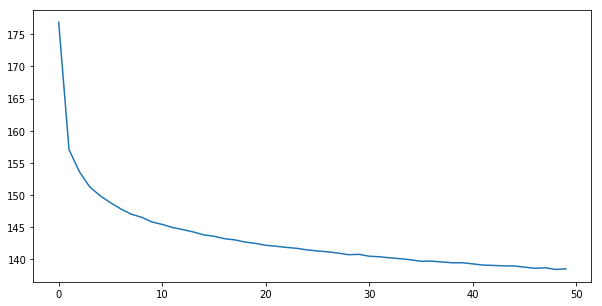

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(x,epoch_losses)
plt.show()

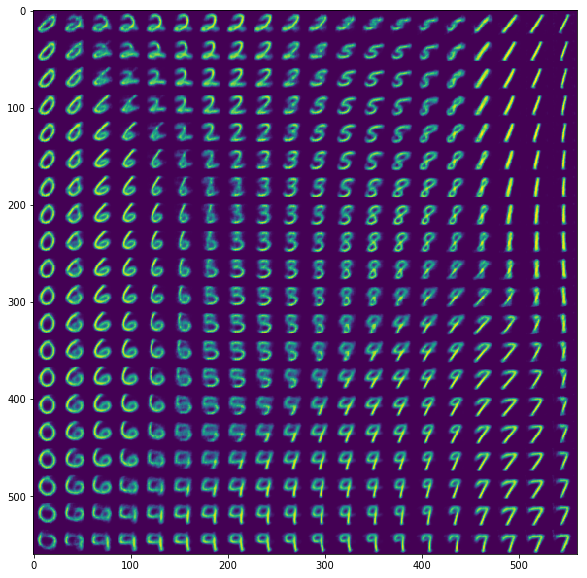

In [0]:
# Visualize digits generated from latent space grid
from scipy.stats import norm
def generate_from_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = torch.FloatTensor([[x,y]])
            z = z.cuda()
            image = model.decoder(z)
#             print(image)
#             break
            image = image.cpu()
            image = image.detach().numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid)
    plt.show()
    
#using gaussian range of 
generate_from_decoder(model)